# Identify tesk-modulated electrodes
See Voytek, 2015 for procedural example; analogous to common single-unit analyses, we will identify task-modulated electrodes.

## Setup

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

### Imports

In [2]:
import os
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat


In [3]:
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum

In [4]:
import sys
sys.path.append(f"{PROJECT_PATH}/code")
from plots import plot_tfr, plot_data_spatial, plot_binary_spatial
from utils import zscore_tfr, crop_tfr, subtract_baseline, downsample_tfr
from stats import gen_random_order, shuffle_rows, comp_resampling_pval

### Settings

In [5]:
# choose example condition
# FNAME = 'tfr_words_hit_multitaper.json'

In [6]:
# dataset details
FS = 512 # sampling frequency
TMIN = -1.5 # epoch start time
PATIENTS = ['pat02','pat04','pat05','pat08','pat10','pat11','pat15','pat16',
            'pat17','pat19','pat20','pat21','pat22']

In [7]:
# Specparam parameters
N_JOBS = -1 # number of jobs for parallel processing
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [4, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0.1, 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2.0, # (default: 2.0)
    'aperiodic_mode'           :   'knee'}

# power analysis (will remove edge artifacts)
WINDOW = 1 # window size for pre/post stimulus power analysis
EDGE = 0.3 # window size for spectral decomposition
N_DOWNSAMPLE = 128 

# band anlysis
# BANDS = Bands({'alpha' : [8, 20]})

### Functions

## Main

### Load example spectrogram data and parmeters

In [7]:
# load example tfr param results

# init
example_index = 1
dir_input = f"{PROJECT_PATH}/data/ieeg_tfr_param/"
files = os.listdir(dir_input)
files = [f for f in files if f.endswith('.json')]
file = files[example_index]

# load param results
fg = FOOOFGroup()
fg.load(f"{dir_input}/{file}")

#extract parameters
exp = fg.get_params('aperiodic_params', 'exponent')
alpha = get_band_peak_fg(fg, [8, 20])

# print
print(f"Example file: {file}")
print(f"exponent shape: {exp.shape}")
print(f"exponent mean: {np.mean(exp):.2f}")
print(f"exponent std: {np.std(exp):.2f}")
print(f"alpha shape: {alpha.shape}")
print(f"alpha mean: {np.mean(alpha, axis=0)}")
print(f"alpha std: {np.std(alpha, axis=0)}")

Example file: pat02_faces_hit_chan0_tfr_multitaper_param_knee.json
exponent shape: (128,)
exponent mean: 3.28
exponent std: 0.27
alpha shape: (128, 3)
alpha mean: [nan nan nan]
alpha std: [nan nan nan]


c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\fooof\objs\group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


tfr shape: (49, 128, 2049)
freq shape: (128,)
time shape: (2049,)


Text(0.5, 1.0, 'Example spectrogram')

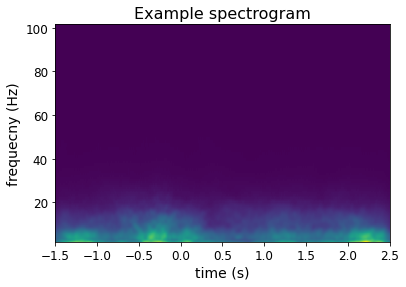

In [8]:
# load tfr
dir_input = f"{PROJECT_PATH}/data/ieeg_tfr/"
fname_in = file.replace('_param', '').replace('_fixed','').replace('_knee', '').replace('.json', '.npz')
data_in = np.load(f"{dir_input}/{fname_in}")
tfr = np.squeeze(data_in['tfr'])
freq = data_in['freq']
time = data_in['time']

# print
print(f"tfr shape: {tfr.shape}")
print(f"freq shape: {freq.shape}")
print(f"time shape: {time.shape}")

# plot
fig, ax = plt.subplots()
ax.pcolormesh(time, freq, np.mean(tfr,axis=0), cmap='viridis')
ax.set(xlabel="time (s)", ylabel="frequecny (Hz)")
ax.set_title("Example spectrogram")


In [9]:
print(f"tfr shape: {tfr.shape}")
print(f"time shape: {time.shape}")
tfr_ds, time_ds = downsample_tfr(tfr, time, N_DOWNSAMPLE)
print(f"tfr_ds shape: {tfr_ds.shape}")
print(f"time_ds shape: {time_ds.shape}")


tfr shape: (49, 128, 2049)
time shape: (2049,)
tfr_ds shape: (49, 128, 128)
time_ds shape: (128,)


normalized tfr shape: (128, 118)
new time shape: (118,)


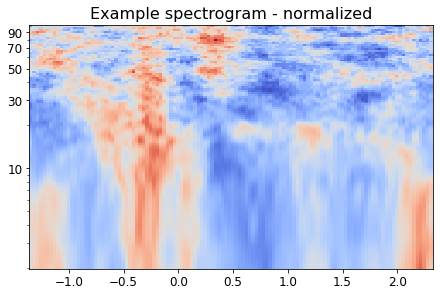

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Example spectrogram - normalized'}>)

In [10]:
 # pre-process tfr

# downsample
tfr_ds, time_ds = downsample_tfr(tfr, time, N_DOWNSAMPLE)

# average over trials
tfr_mean = np.mean(tfr_ds, axis=0)

# crop tfr (edge artiifacts)
tfr_c, time_c = crop_tfr(tfr_mean, time_ds, [time_ds[0]+(EDGE/2), time_ds[-1]-(EDGE/2)])

# normalize tfr
tfr_norm = zscore_tfr(tfr_c)

# subtract baseline
tfr_norm = subtract_baseline(tfr_norm, time_c, [time[0]+(EDGE/2), 0])

# print
print(f"normalized tfr shape: {tfr_norm.shape}")
print(f"new time shape: {time_c.shape}")

# plot
plot_tfr(time_c, freq, tfr_norm, norm_type='two_slope', title="Example spectrogram - normalized")


In [11]:
# compute alpha bandpowr time-series

# trim tfr in alpha band and average across the band
_, alpha_band_ts = trim_spectrum(freq, tfr_norm.T, f_range=BANDS['alpha'])
alpha_bp = np.mean(alpha_band_ts, axis=1)
print(f"alpha band time-series shape: {alpha_band_ts.shape}")
print(f"alpha band power shape: {alpha_bp.shape}")

alpha band time-series shape: (118, 29)
alpha band power shape: (118,)


Text(0.5, 0.98, 'Example spectral parameter timeseries')

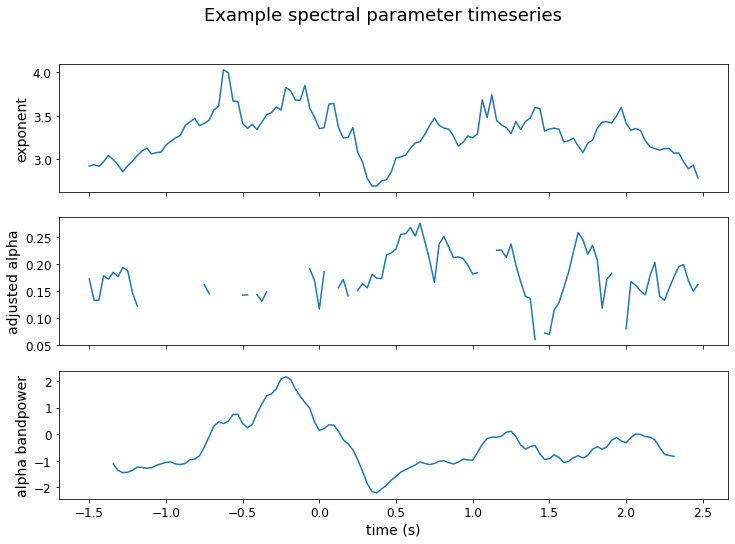

In [12]:
# plot 3 paramter time-series
fig, ax = plt.subplots(3,1, sharex=True, figsize=[12,8])
ax[0].plot(time_ds, exp)
ax[0].set(ylabel="exponent")
ax[1].plot(time_ds, alpha[:,1])
ax[1].set(ylabel="adjusted alpha")
ax[2].plot(time_c, alpha_bp)
ax[2].set(ylabel="alpha bandpower")
ax[2].set(xlabel="time (s)")
fig.suptitle("Example spectral parameter timeseries")


### Compute alpha modulation index

In [13]:
 # pre-process tfr

# 
tfr_raw = np.squeeze(data_in['tfr'])
print(tfr_raw.shape)

# crop edge artifacts of power analysis
tfr, time = crop_tfr(tfr_raw, data_in['time'], 
                     [time_ds[0]+(EDGE/2), time_ds[-1]-(EDGE/2)])
print(tfr.shape, time.shape)

# trim tfr in alpha band and average across the band
_, alpha_band_ts = trim_spectrum(freq, tfr, f_range=BANDS['alpha'])
print(alpha_band_ts.shape)

(49, 128, 2049)
(49, 128, 1879) (1879,)
(49, 29, 1879)


In [14]:
# compute mean pre/post-stimulus alpha bandpower
# alpha_pre = np.mean(alpha_bp[time < 0])
# alpha_post = np.mean(alpha_bp[time > 0])
alpha_pre = alpha_band_ts[...,time < 0]
alpha_post = alpha_band_ts[...,time > 0]

# print
print(f"alpha band power shape: {alpha_pre.shape}")
print(f"mean alpha pre-stimulus: {np.mean(alpha_pre):.2f}")
print(f"mean alpha post-stimulus: {np.mean(alpha_post):.2f}")

alpha band power shape: (49, 29, 691)
mean alpha pre-stimulus: 27640.70
mean alpha post-stimulus: 22753.84


In [10]:
def comp_alpha_bandpower(tfr, freq, time, f_range=[8, 20], window=1, edge=0.3, 
                         average=True, print_results=True):
    """Compute alpha bandpower time-series from TFR data.
    
    Parameters
    ----------
    tfr : array 
        Time-frequency representation of the signal. Can be 2 or 3 dimensional.
        If 2d, (freq x time). If 3D (trials x freq x time)
    freq : 1d array
        Frequency values.
    time : 1d array
        Time values. The length of time should match the last dimension of tfr.
    f_range : arrav of 2 floats, optional   
        Alpha frequency range, by default [8, 20].
    window : float, optional
    edge : float, optional
        Window size used power analysis. The tfr will be cropped to remove 
        edge artifacts, by default 0.3.
    average : bool, optional
        If True, average across the alpha band, by default True.
    print_results : bool, optional
        If True, print mean alpha bandpower pre/post-stimulus, by default True.
    
    Returns
    -------
    alpha_pre, alpha_post : arrays
        Alpha bandpower time-series for pre and post-stimulus periods.
    """

    # crop edge artifacts of power analysis
    tfr, time = crop_tfr(tfr, time, [time[0]+(edge/2), time[-1]-(edge/2)])

    # trim tfr in alpha band and average across the band
    _, alpha_band_ts = trim_spectrum(freq, tfr, f_range=f_range)

    # compute mean pre/post-stimulus alpha bandpower
    alpha_pre = alpha_band_ts[..., np.logical_and(time>-window, time<0)]
    alpha_post = alpha_band_ts[..., np.logical_and(time>0, time<window)]

    # average over band (if requested)
    if average:
        alpha_pre = np.mean(alpha_pre, axis=1)
        alpha_post = np.mean(alpha_post, axis=1)

    # print results
    if print_results:
        print(f"mean alpha pre-stimulus: {np.mean(alpha_pre):.2f}")
        print(f"mean alpha post-stimulus: {np.mean(alpha_post):.2f}")
    
    return alpha_pre, alpha_post

In [60]:
# apply function
alpha_pre, alpha_post = comp_alpha_bandpower(np.squeeze(data_in['tfr']), data_in['freq'], 
                                             data_in['time'], f_range=BANDS['alpha'], 
                                             edge=EDGE, window=WINDOW, print_results=True)

mean alpha pre-stimulus: 18571.54
mean alpha post-stimulus: 11370.15


mean alpha shuffled a: 14960.01
mean alpha shuffled b: 14981.68
mean shuffled difference: -21.66
Empirical change in alpha bandpower: -7201.39
p value: 0.0
Sign of difference: -1


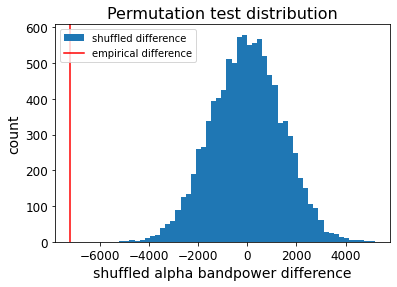

In [71]:
# permutation statistics 

# settings
i_chan = 0 # example channel 
n_iter = 10000 # number of iterations

# shuffle conditions
order = gen_random_order(n_iter, alpha_pre.shape[0]*2)
alpha_pre_shuf, alpha_post_shuf = shuffle_rows(alpha_pre, alpha_post, order)

# average over time windows and trials and compute difference
alpha_a = np.mean(alpha_post_shuf, axis=(1,2))
alpha_b = np.mean(alpha_pre_shuf, axis=(1,2))
alpha_distr = alpha_a - alpha_b
print(f"mean alpha shuffled a: {np.mean(alpha_a):.2f}")
print(f"mean alpha shuffled b: {np.mean(alpha_b):.2f}")
print(f"mean shuffled difference: {np.mean(alpha_distr):.2f}")
# print(f"% change: {np.mean(alpha_distr) / np.mean(alpha_pre[:, i_chan]):.5f}")

# compute p value
alpha_diff = np.mean(alpha_post) - np.mean(alpha_pre)
p_val, sign = comp_resampling_pval(alpha_distr, alpha_diff)
print(f'Empirical change in alpha bandpower: {alpha_diff:.2f}')
print(f"p value: {p_val}")
print(f"Sign of difference: {sign}")

# plot
plt.hist(alpha_distr, bins=50, label='shuffled difference')
plt.axvline(alpha_diff, color='r', label='empirical difference')
plt.xlabel("shuffled alpha bandpower difference")
plt.ylabel("count")
plt.title("Permutation test distribution")
plt.legend()

#### put it all together

In [7]:
# settings
n_iter = 10000 # number of iterations/shuffles for resampling analysis

# choose example file
i_file = 1 # example file
dir_input = f"{PROJECT_PATH}/data/ieeg_tfr/"
files = os.listdir(dir_input)
file = files[i_file]

In [8]:

def task_modulation(fname_in):
    # load tfr
    data_in = np.load(fname_in)

    # compute alpha bandpower for pre/post-stim time window
    alpha_pre, alpha_post = comp_alpha_bandpower(np.squeeze(data_in['tfr']), data_in['freq'], 
                                                data_in['time'], f_range=BANDS['alpha'], 
                                                edge=EDGE, window=WINDOW, average=True, 
                                                print_results=False)

    # shuffle conditions
    order = gen_random_order(n_iter, alpha_pre.shape[0]*2)
    alpha_pre_shuf, alpha_post_shuf = shuffle_rows(alpha_pre, alpha_post, order)

    # average shuffled power values over time windows and trials, then compute difference
    alpha_a = np.mean(alpha_post_shuf, axis=(1,2))
    alpha_b = np.mean(alpha_pre_shuf, axis=(1,2))
    alpha_distr = alpha_a - alpha_b

    # compute p value
    alpha_diff = np.mean(alpha_post) - np.mean(alpha_pre)
    p_val, sign = comp_resampling_pval(alpha_distr, alpha_diff)

    return p_val, sign

In [11]:
p_val, sign = task_modulation(f"{dir_input}/{file}")
if p_val==0:    
    print(f"p value < {1/n_iter}")
else:    
    print(f"p value: {p_val}")
print(f"Sign of difference: {sign}")

p value < 0.0001
Sign of difference: -1


#### examine results of X_id_modulated_chans

In [8]:
# load results - alpha/beta bandpower modulation (resampling analysis)
results = pd.read_csv(f"{PROJECT_PATH}/data/results/ieeg_modulated_channels.csv")

# add significan column
ALPHA = 0.05
results['sig'] = results['p_val']<ALPHA

# print results
n_sig_chans = np.sum(results['sig'])
percent_sig = n_sig_chans / len(results) * 100
print(f"Number of significant channels: {n_sig_chans} ({percent_sig:.2f}%)")

results


Number of significant channels: 821 (30.63%)


,Unnamed: 0,patient,channel,material,memory,p_val,sign,sig
0,0,pat02,chan0,faces,hit,0.0002,-1.0,True
1,1,pat02,chan1,faces,hit,0.0000,-1.0,True
2,2,pat02,chan2,faces,hit,0.0000,-1.0,True
3,3,pat02,chan3,faces,hit,0.3376,-1.0,False
4,4,pat02,chan4,faces,hit,0.0074,-1.0,True
...,...,...,...,...,...,...,...,...
2675,2675,pat22,chan5,words,miss,0.0000,-1.0,True
2676,2676,pat22,chan6,words,miss,0.0000,-1.0,True
2677,2677,pat22,chan7,words,miss,0.0000,-1.0,True
2678,2678,pat22,chan8,words,miss,0.0000,-1.0,True


In [9]:
# load channel info
chan_info = pd.read_pickle(f'{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.pkl')
chan_info

,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,0,pat02,0,A01-A02,-65.431,61.9449,3.55955
1,1,pat02,1,A02-A03,-70.93895,57.17765,12.1554
2,2,pat02,2,A03-A04,-75.3955,51.3944,20.94335
3,3,pat02,3,A04-A05,-78.9195,43.9098,30.13485
4,4,pat02,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...,...
690,48,pat22,48,MOF_03-MOF_04,36.0,-14.0,3.0
691,49,pat22,49,MOF_04-MOF_07,40.5,-14.0,9.5
692,50,pat22,50,MOF_07-MOF_08,44.5,-14.0,16.5
693,51,pat22,51,MOF_08-MOF_09,48.0,-14.0,23.5


In [10]:
# add channel info to results df by merging

# modfy chan df column names for merging
df_chans = chan_info.copy()
for ii in range(len(df_chans)):
    df_chans.loc[ii, 'channel'] = f"chan{df_chans.loc[ii, 'chan_idx']}"
df_chans

# merge
df = pd.merge(results, df_chans, on=['patient','channel'], how='left')
df

,Unnamed: 0,patient,channel,material,memory,p_val,sign,sig,index,chan_idx,label,pos_y,pos_x,pos_z
0,0,pat02,chan0,faces,hit,0.0002,-1.0,True,0,0,A01-A02,-65.431,61.9449,3.55955
1,1,pat02,chan1,faces,hit,0.0000,-1.0,True,1,1,A02-A03,-70.93895,57.17765,12.1554
2,2,pat02,chan2,faces,hit,0.0000,-1.0,True,2,2,A03-A04,-75.3955,51.3944,20.94335
3,3,pat02,chan3,faces,hit,0.3376,-1.0,False,3,3,A04-A05,-78.9195,43.9098,30.13485
4,4,pat02,chan4,faces,hit,0.0074,-1.0,True,4,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2675,2675,pat22,chan5,words,miss,0.0000,-1.0,True,5,5,IFG_01-IFG_02,16.0,-31.5,12.0
2676,2676,pat22,chan6,words,miss,0.0000,-1.0,True,6,6,IFG_02-IFG_03,17.5,-36.5,10.5
2677,2677,pat22,chan7,words,miss,0.0000,-1.0,True,7,7,IFG_03-IFG_04,19.5,-41.5,9.0
2678,2678,pat22,chan8,words,miss,0.0000,-1.0,True,8,8,IFG_04-IFG_05,21.5,-46.5,7.0


In [11]:
# Load brain mesh data
fname_mesh = r"C:\Users\micha\datasets\SpectraltiltvsOscillations\Scripts\additional scripts\surface_pial_both.mat"
data_mesh = loadmat(fname_mesh)
pos = data_mesh['mesh']['pos'][0][0]
tri = data_mesh['mesh']['tri'][0][0] - 1 # matlab index begins at 1

# define camera postions for each hemispheres
cpos_right = [(522.8751422878058, -8.533968557192056, 2.1119098264702054),
              (0.21547583547528149, -18.471318770726832, 15.236837161591453),
              (0.023688404036230154, 0.07114592740239216, 0.9971845950115104)]
cpos_left = [(-520.3531805339194, -38.83703309211285, 60.37721009778639),
             (0.21547583547528149, -18.471318770726832, 15.236837161591453),
             (0.08481614834082721, 0.038835387452391915, 0.9956395098940428)]

c:\Users\micha\anaconda3\envs\tilt_vs_fingerprint\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Install ``panel`` to use this feature

Falling back to a static output.
  warnings.warn(


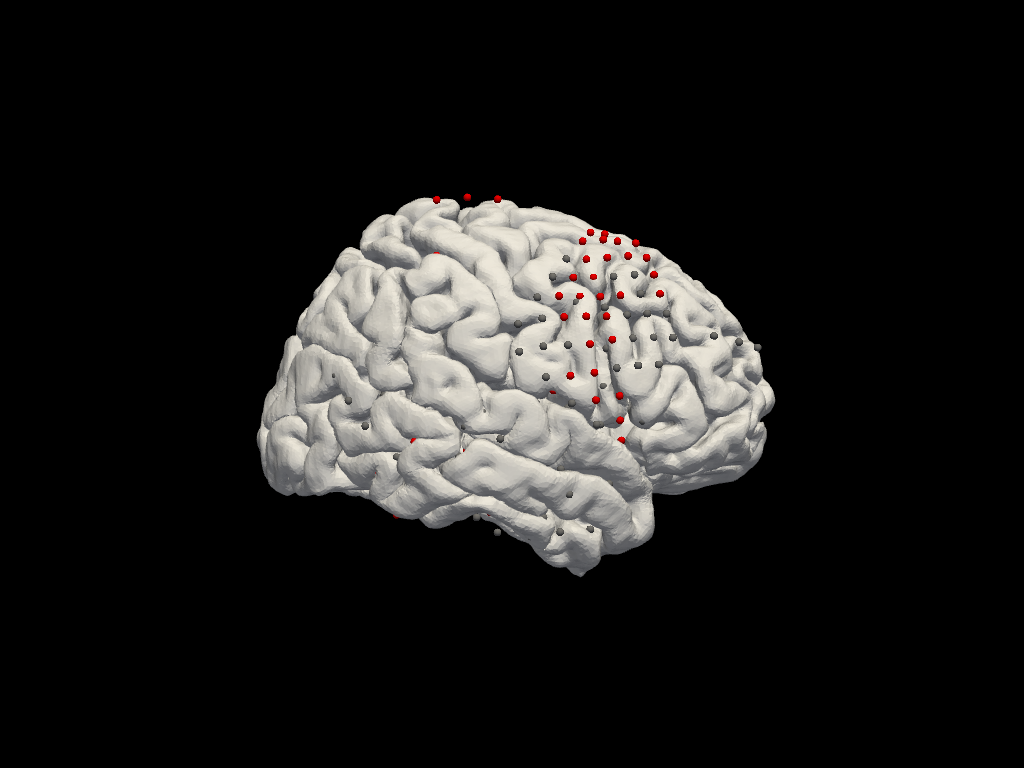

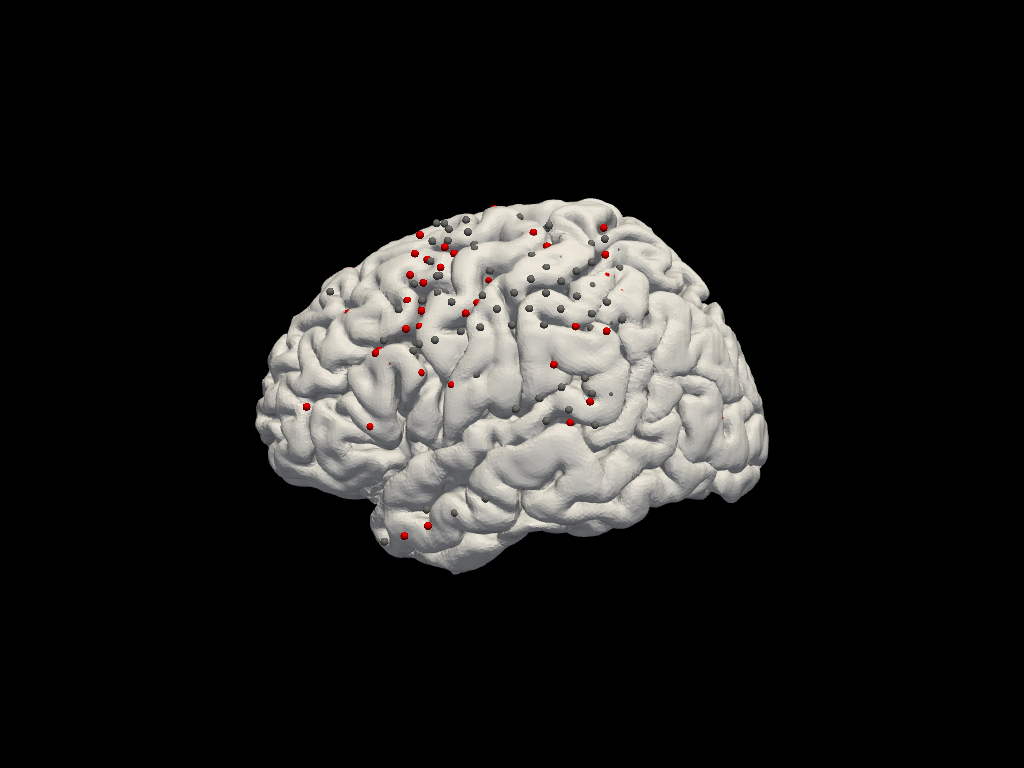

In [15]:
# plot results for an example condition

# get electrode positions and p-values (for a condition)
material = 'words'
memory = 'hit'
df_cond = df[(df['material']==material) &(df['memory']==memory)]
elec_pos = df_cond[['pos_x','pos_y','pos_z']].values.astype(float)
value = df_cond['p_val'].values.astype(float)

# plot
for cpos in [cpos_right, cpos_left]:
    # plot_data_spatial(pos, tri, elec_pos, value, cpos=cpos)
    plot_binary_spatial(pos, tri, elec_pos, df_cond['sig'], cpos=cpos)
    

In [3]:
# # plot significant electrodes for each condition

# for material in ['words','faces']:
#     for memory in ['hit','miss']:
#         df_cond = df[(df['material']==material) &(df['memory']==memory)]
#         elec_pos = df_cond[['pos_x','pos_y','pos_z']].values.astype(float)
#         # plot_binary_spatial(pos, tri, elec_pos, df_cond['sig'], cpos=cpos_right)
#         plot_binary_spatial(pos, tri, elec_pos, df_cond['sig'], cpos=cpos_left)



#### merge with primary results

In [25]:
# merge with alpha bandpower results

# drop memory = 'miss'
df_bp = results[results['memory']=='hit']
df_bp
# merge
# df = pd.merge(df_bp, df_perm, on=['subject', 'material', 'channel'])


,Unnamed: 0,patient,channel,material,memory,p_val,sign
0,0,pat02,chan0,faces,hit,0.0002,-1.0
1,1,pat02,chan1,faces,hit,0.0000,-1.0
2,2,pat02,chan2,faces,hit,0.0000,-1.0
3,3,pat02,chan3,faces,hit,0.3376,-1.0
4,4,pat02,chan4,faces,hit,0.0074,-1.0
...,...,...,...,...,...,...,...
2622,2622,pat22,chan5,words,hit,0.0000,-1.0
2623,2623,pat22,chan6,words,hit,0.0000,-1.0
2624,2624,pat22,chan7,words,hit,0.0000,-1.0
2625,2625,pat22,chan8,words,hit,0.0000,-1.0


In [10]:
# load channel info
chan_info = np.load(f'{PROJECT_PATH}/data/ieeg_metadata/ieeg_channel_info.pkl',
    allow_pickle=True)
chan_info

,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,0,pat02,0,A01-A02,-65.431,61.9449,3.55955
1,1,pat02,1,A02-A03,-70.93895,57.17765,12.1554
2,2,pat02,2,A03-A04,-75.3955,51.3944,20.94335
3,3,pat02,3,A04-A05,-78.9195,43.9098,30.13485
4,4,pat02,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...,...
690,48,pat22,48,MOF_03-MOF_04,36.0,-14.0,3.0
691,49,pat22,49,MOF_04-MOF_07,40.5,-14.0,9.5
692,50,pat22,50,MOF_07-MOF_08,44.5,-14.0,16.5
693,51,pat22,51,MOF_08-MOF_09,48.0,-14.0,23.5


In [13]:
# load permutation statistical results 
# NOTE: step 6 has been updated to export a df of these results across all files with the info of interest
# Step 6 must still be re-run for both memory conditions

dfs = []
for material in ['face', 'word']:
    # load results and convert to dataframe
    df = pd.DataFrame()
    data_in = np.load(f"{PROJECT_PATH}/data/ieeg_stats/permutation_test/group_stats_{material}_knee.npz") 
    for var in data_in.files:
        df[var] = data_in[var]
    df['material'] = material

    # combine with channel info
    df = df.join(chan_info)

    dfs.append(df)

df_perm = pd.concat(dfs)
df_perm


,pval_alpha,pval_exp,sign_exp,sign_alpha,material,index,patient,chan_idx,label,pos_y,pos_x,pos_z
0,0.14,0.86,1.0,-1.0,face,0,pat02,0,A01-A02,-65.431,61.9449,3.55955
1,0.00,0.06,-1.0,0.0,face,1,pat02,1,A02-A03,-70.93895,57.17765,12.1554
2,0.00,0.16,-1.0,0.0,face,2,pat02,2,A03-A04,-75.3955,51.3944,20.94335
3,0.08,0.74,-1.0,1.0,face,3,pat02,3,A04-A05,-78.9195,43.9098,30.13485
4,0.00,0.00,-1.0,0.0,face,4,pat02,4,A05-A06,-80.96735,35.21485,38.13475
...,...,...,...,...,...,...,...,...,...,...,...,...
690,0.18,0.54,-1.0,1.0,word,48,pat22,48,MOF_03-MOF_04,36.0,-14.0,3.0
691,0.00,0.26,1.0,0.0,word,49,pat22,49,MOF_04-MOF_07,40.5,-14.0,9.5
692,0.00,0.06,-1.0,0.0,word,50,pat22,50,MOF_07-MOF_08,44.5,-14.0,16.5
693,0.00,0.00,-1.0,0.0,word,51,pat22,51,MOF_08-MOF_09,48.0,-14.0,23.5
